In [1]:
require("RPostgreSQL")
require("xts")
library(quantmod)
pw <- {
  ""
}
# host <- 'localhost'
host <- '192.168.0.20'
drv <- dbDriver("PostgreSQL")
con <- dbConnect(drv, dbname = "postgres",
                 host = host, port = 5432,
                 user = "postgres")



Loading required package: RPostgreSQL
Loading required package: DBI
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.


In [2]:
instrument <- 'EUR_USD'
fromDate <- '2010-07-10 00:00:00'
toDate <- '2010-07-15 23:59:00'
period <- '5min'
fromtbl <- paste("oanda",instrument,"m1", sep = '_')

win_agg_group_sql <- paste("  with intervals as (
  select start, start + interval '", period ,"' as end
  from generate_series('" , fromDate , "', '", toDate,"', interval '", period ,"' ) as start
  )
  select distinct
  intervals.start as dt,
  min(bid_l) over w as low,
  max(bid_h) over w as high,
  first_value(bid_o) over w as open,
  last_value(bid_c) over w as close,
  sum(v) over w as volume
  from
  intervals
  join ",fromtbl," tmb on
  tmb.dt >= intervals.start and
  tmb.dt < intervals.end
  window w as (partition by intervals.start)
  order by intervals.start; "
)


inst_df <- dbGetQuery(con,win_agg_group_sql)

In [3]:
 
# as.POSIXlt(fr$dt,'UTC')
#fr <- data.frame(fr[,-1], row.names=fr[,1])
#str(fr)
#r <- xts(as.matrix(fr[,-1]), order.by=as.Date(fr[,1]), updated=Sys.time()) 
inst_xts <- xts(as.matrix(inst_df[,-1]), order.by=inst_df[,1])
# data.frame(date=index(master_1), coredata(master_1))
# PRICE$DATE <- as.Date(as.character(PRICE$DATE),format="%Y%m%d")
# fr$dt

In [68]:
inst_xts

                        low    high    open   close volume
2010-07-11 11:35:00 1.26297 1.26327 1.26327 1.26297      2
2010-07-11 11:40:00 1.26326 1.26359 1.26326 1.26351      4
2010-07-11 11:45:00 1.26351 1.26354 1.26354 1.26351      4
2010-07-11 11:50:00 1.26351 1.26354 1.26354 1.26351      4
2010-07-11 11:55:00 1.26351 1.26370 1.26354 1.26365     15
2010-07-11 12:00:00 1.26180 1.26379 1.26379 1.26210    107
2010-07-11 12:05:00 1.26185 1.26213 1.26204 1.26188     21
2010-07-11 12:10:00 1.26190 1.26306 1.26190 1.26290     84
2010-07-11 12:15:00 1.26233 1.26283 1.26282 1.26247     29
2010-07-11 12:20:00 1.26230 1.26257 1.26251 1.26230     13
2010-07-11 12:25:00 1.26117 1.26226 1.26226 1.26145     89
2010-07-11 12:30:00 1.26134 1.26158 1.26141 1.26136     20
2010-07-11 12:35:00 1.26132 1.26142 1.26139 1.26135      8
2010-07-11 12:40:00 1.26137 1.26156 1.26137 1.26156      9
2010-07-11 12:50:00 1.26150 1.26198 1.26158 1.26182     45
2010-07-11 12:55:00 1.26184 1.26204 1.26184 1.26200     

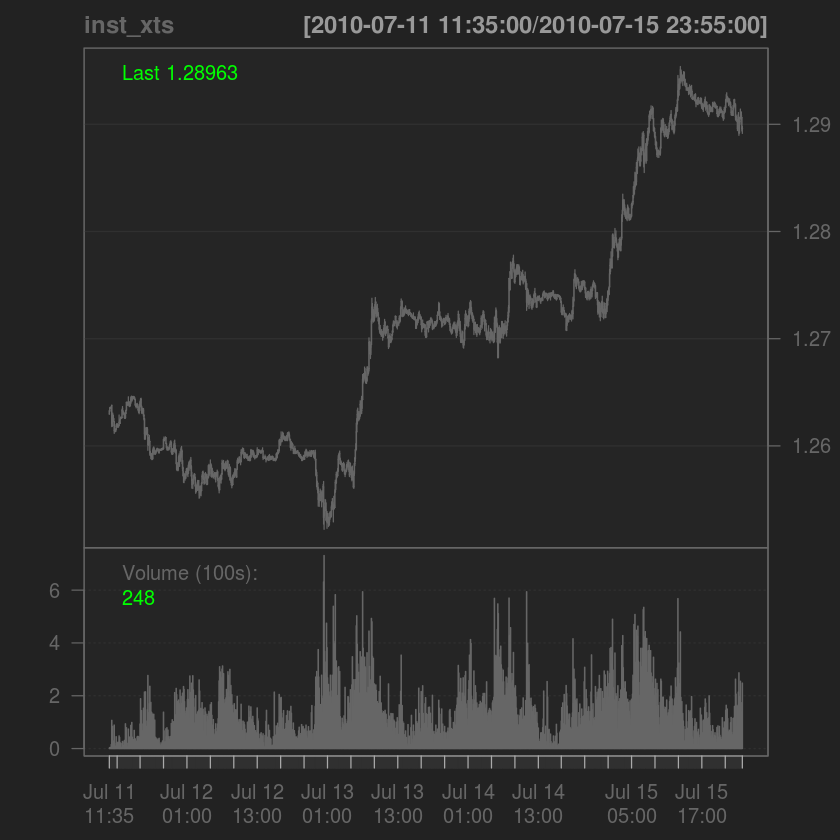

In [4]:
candleChart(inst_xts)